In [1]:
from tensorflow.keras import models, layers
from tensorflow import keras
from data_handler import get_selected_data
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import pickle
import matplotlib.pyplot as plt

2022-06-23 09:38:16.498209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 09:38:16.498228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [39]:
data = get_selected_data()

In [42]:
trajectories = [tmd["traj_data"] for tmd in data if tmd["class"] != "train" and tmd["class"] != "bus"]
classes = [tmd["class"] for tmd in data if tmd["class"] != "train" and tmd["class"] != "bus"]

In [43]:
le = preprocessing.LabelEncoder()
le.fit(classes)
for cls, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(lbl, cls)
labeled_classes = le.transform(classes)
print("\nAll classes labeled:", labeled_classes)

0 bike
1 car
2 walk

All classes labeled: [2 1 1 ... 2 2 2]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    trajectories, labeled_classes, stratify=labeled_classes, random_state=0, test_size=0.20,
)

X_validation, X_test, y_validation, y_test = train_test_split(
    X_test, y_test, stratify=y_test, random_state=0, test_size=0.10,
)

In [45]:
def prepare_data(trajs, cls, hist_size=75):
    X, y = [], []
    for traj, cls in zip(trajs, cls):
        X.append(traj[-hist_size:])
        y.append(cls)
    return np.array(X), np.array(y)

def plot_model_results(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def save_history(model, file_name="history"):
    with open(file_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [46]:
last_n_points = 100
tX, ty = prepare_data(X_train, y_train, last_n_points)
vX, vy = prepare_data(X_validation, y_validation, last_n_points)
teX, tey = prepare_data(X_test, y_test, last_n_points)

In [47]:
def predict(trajs, model, hist_size=75, cls = None):
    if cls is None:
        cls = [""] * len(trajs)
    for traj, cl in zip(trajs, cls):
        X, _ = prepare_data([traj], [0], hist_size)
        pred = model.predict(X)
        print(pred[-1], np.argmax(pred[-1], axis=0), cl)

In [52]:
model = keras.Sequential()

model.add(layers.LSTM(128, input_shape=(last_n_points, 3), return_sequences=True))
model.add(layers.LSTM(64, input_shape=(last_n_points, 3), return_sequences=True))
model.add(layers.Bidirectional(layers.LSTM(32, input_shape=(last_n_points, 3)), merge_mode='ave'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()


es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc = keras.callbacks.ModelCheckpoint('best_model_9.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(tX, ty, epochs=30, callbacks=[mc, es], validation_data=(vX, vy))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 100, 128)          67584     
                                                                 
 lstm_40 (LSTM)              (None, 100, 64)           49408     
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               24832     
 onal)                                                           
                                                                 
 dense_25 (Dense)            (None, 15)                495       
                                                                 
 dense_26 (Dense)            (None, 3)                 48        
                                                                 
Total params: 142,367
Trainable params: 142,367
Non-trainable params: 0
_______________________________________________

67/67 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.5982
Epoch 26: accuracy did not improve from 0.60432
67/67 [==============================] - 4s 66ms/step - loss: 0.8985 - accuracy: 0.5982 - val_loss: 0.8943 - val_accuracy: 0.6013
Epoch 27/30
67/67 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.5977
Epoch 27: accuracy did not improve from 0.60432
67/67 [==============================] - 4s 66ms/step - loss: 0.8998 - accuracy: 0.5977 - val_loss: 0.8849 - val_accuracy: 0.6180
Epoch 28/30
67/67 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.6015
Epoch 28: accuracy did not improve from 0.60432
67/67 [==============================] - 4s 66ms/step - loss: 0.8968 - accuracy: 0.6015 - val_loss: 0.8987 - val_accuracy: 0.6075
Epoch 29/30
67/67 [==============================] - ETA: 0s - loss: 0.8963 - accuracy: 0.5996
Epoch 29: accuracy did not improve from 0.60432
67/67 [==============================] - 4s 67ms/s

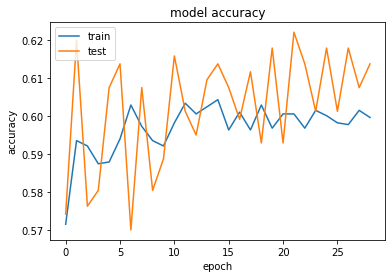

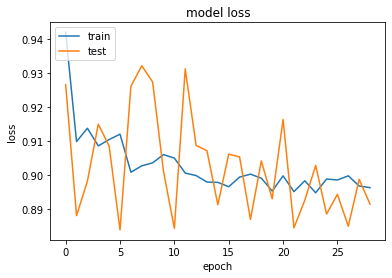

In [53]:
save_history(history.history, "history_78")
plot_model_results(history.history)

In [54]:
print(model.evaluate(teX, tey))
print()
predict(X_test[:20], model, last_n_points, y_test[:20])

2/2 [==============================] - 0s 18ms/step - loss: 0.8280 - accuracy: 0.6667
[0.8279731273651123, 0.6666666865348816]

1/1 [==============================] - 1s 693ms/step
[0.333195  0.3266186 0.3401864] 2 0
1/1 [==============================] - 0s 15ms/step
[0.15967935 0.10519698 0.7351237 ] 2 2
1/1 [==============================] - 0s 14ms/step
[0.2839562  0.09150782 0.62453604] 2 2
1/1 [==============================] - 0s 15ms/step
[0.5670773  0.17617087 0.25675187] 0 0
1/1 [==============================] - 0s 14ms/step
[0.4001557 0.2641862 0.3356581] 0 0
1/1 [==============================] - 0s 15ms/step
[0.6098781  0.13502957 0.25509232] 0 2
1/1 [==============================] - 0s 14ms/step
[0.5954869  0.16116312 0.24334994] 0 0
1/1 [==============================] - 0s 16ms/step
[0.2797637  0.10431297 0.61592335] 2 2
1/1 [==============================] - 0s 15ms/step
[0.2772837  0.10183292 0.6208834 ] 2 0
1/1 [==============================] - 0s 16ms/step
[0.302